In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Load data
df = pd.read_pickle("../../data/processed/data_with_engineered_features.pkl")
# Cut half of the data evenly across labels
#df = df.groupby('label').apply(lambda x: x.sample(frac=0.5, random_state=42)).reset_index(drop=True)
# Example target
y = df["label"]

# Example feature sets
fs1 = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
fs2 = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z","pca_1","pca_2","pca_3"]
fs3 = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z","lda_1","lda_2","lda_3"]
fs4 = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z","acc_x_roll","acc_y_roll","acc_z_roll","gyro_x_roll","gyro_y_roll","gyro_z_roll"]
fs5 = ["lda_1","lda_2","lda_3","acc_x_roll","acc_y_roll"]
fs6 = ['acc_y', 'pca_2', 'acc_x_roll', 'acc_y_roll', 'acc_z_roll', 'gyro_z_roll']
fs7 = ['acc_x', 'gyro_x', 'gyro_z', 'lda_1', 'lda_2', 'acc_x_roll', 'acc_y_roll', 'acc_z_roll', 'gyro_x_roll', 'gyro_z_roll']

feature_sets = [fs1, fs2, fs3, fs4, fs5, fs6, fs7]

# Models and parameter grids
models = {
    "LogisticRegression": (
        LogisticRegression(max_iter=1000),
        {"clf__C": [0.01, 0.1, 1, 10]}
    ),
    "RandomForest": (
        RandomForestClassifier(),
        {
            "clf__n_estimators": [50, 100, 200],
            "clf__max_depth": [5, 10, 20, 30, 40,None],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__bootstrap": [True, False]
        }
    ),
    "NaiveBayes": (
        GaussianNB(),
        {}
    ),
    "NeuralNetwork": (
        MLPClassifier(max_iter=1000),
        {"clf__hidden_layer_sizes": [(50,), (100,), (50, 50)], "clf__alpha": [0.0001, 0.001, 0.01]}
    ),
    "DecisionTree": (
        DecisionTreeClassifier(),
        {"clf__max_depth": [5, 10, None], "clf__min_samples_split": [2, 5, 10]}
    )
}

results = []

for i, fs in enumerate(feature_sets, start=1):
    X = df[fs].fillna(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for m_name, (m_model, m_params) in models.items():
        pipe = Pipeline([("scaler", StandardScaler()), ("clf", m_model)])
        gsearch = GridSearchCV(pipe, param_grid=m_params, cv=3, n_jobs=-1)

        start_time = time.time()
        gsearch.fit(X_train, y_train)
        training_time = time.time() - start_time

        best_model = gsearch.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        results.append({
            "model": m_name,
            "feature_set": i,
            "best_params": gsearch.best_params_,
            "accuracy": acc,
            "training_time": training_time
        })

res_df = pd.DataFrame(results)
print(res_df)


                 model  feature_set  \
0   LogisticRegression            1   
1         RandomForest            1   
2           NaiveBayes            1   
3        NeuralNetwork            1   
4         DecisionTree            1   
5   LogisticRegression            2   
6         RandomForest            2   
7           NaiveBayes            2   
8        NeuralNetwork            2   
9         DecisionTree            2   
10  LogisticRegression            3   
11        RandomForest            3   
12          NaiveBayes            3   
13       NeuralNetwork            3   
14        DecisionTree            3   
15  LogisticRegression            4   
16        RandomForest            4   
17          NaiveBayes            4   
18       NeuralNetwork            4   
19        DecisionTree            4   
20  LogisticRegression            5   
21        RandomForest            5   
22          NaiveBayes            5   
23       NeuralNetwork            5   
24        DecisionTree   

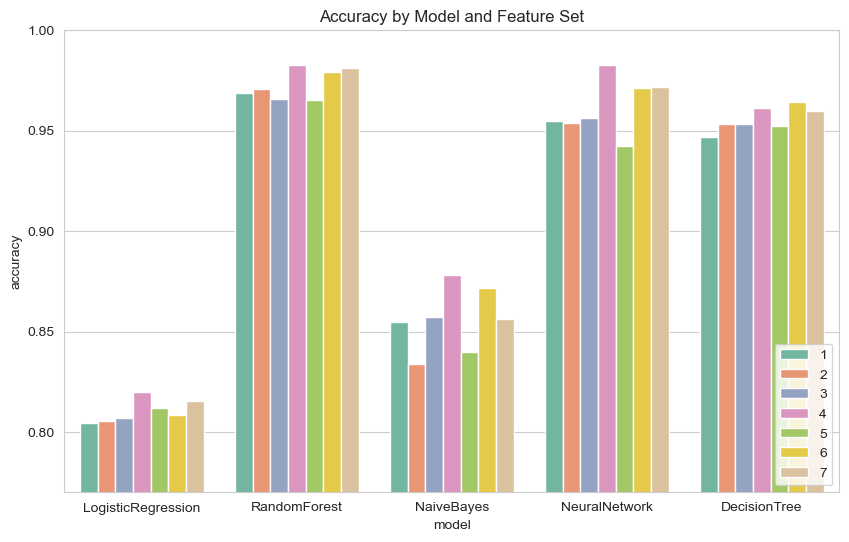

In [2]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="accuracy", hue="feature_set", data=res_df, palette="Set2")
plt.ylim(0.77, 1)
plt.title("Accuracy by Model and Feature Set")
plt.legend(loc='lower right')
plt.show()

In [15]:
results

In [ ]:
from sklearn.metrics import classification_report

df = pd.read_pickle("../../data/processed/data_with_engineered_features.pkl")
# Exclude participant 'A' from training
train_df = df[df['participant'] != 'A']
X_train = train_df[fs6]
y_train = train_df['label']

# Use only participant 'A' for testing
test_df = df[df['participant'] == 'A']
X_test = test_df[fs6]
y_test = test_df['label']

# Create and configure the pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier())
])

# Set RandomForest parameters
params = {
    "clf__bootstrap": False,
    "clf__max_depth": 30,
    "clf__min_samples_leaf": 1,
    "clf__min_samples_split": 2,
    "clf__n_estimators": 50
}
pipe.set_params(**params)

# Train and evaluate
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on participant A:", acc)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy on participant A: 0.9778169901688933
Classification Report:
               precision    recall  f1-score   support

       bench       0.82      1.00      0.90       370
        dead       1.00      0.99      1.00       709
         ohp       1.00      0.91      0.95       963
        rest       1.00      1.00      1.00       984
         row       0.97      1.00      0.99       113
       squat       1.00      1.00      1.00       828

    accuracy                           0.98      3967
   macro avg       0.96      0.98      0.97      3967
weighted avg       0.98      0.98      0.98      3967



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_pickle("../../data/processed/data_with_engineered_features.pkl")

# Example target
y = df["label"]

# Example feature sets
fs1 = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
fs2 = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z","pca_1","pca_2","pca_3"]
fs3 = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z","lda_1","lda_2","lda_3"]
fs4 = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z","acc_x_roll","acc_y_roll", "acc_z_roll","gyro_x_roll","gyro_y_roll","gyro_z_roll"]
fs5 = ["lda_1","lda_2","lda_3","acc_x_roll","acc_y_roll"]
fs6 = ['acc_y', 'pca_2', 'acc_x_roll', 'acc_y_roll', 'acc_z_roll', 'gyro_z_roll']
fs7 = ['acc_x', 'gyro_x', 'gyro_z', 'lda_1', 'lda_2', 'acc_x_roll', 'acc_y_roll', 'acc_z_roll', 'gyro_x_roll', 'gyro_z_roll']


feature_sets = [fs1, fs2, fs3, fs4, fs5, fs6, fs7]

# Models and parameter grids
models = {
    "LogisticRegression": (LogisticRegression(max_iter=1000),
        {"clf__C": [0.01, 0.1, 1, 10]}),
    "RandomForest": (RandomForestClassifier(),
        {"clf__n_estimators": [50, 100], "clf__max_depth": [5, 10, None]}),
    "NaiveBayes": (GaussianNB(),
        {}),
    "NeuralNetwork": (MLPClassifier(max_iter=1000),
        {"clf__hidden_layer_sizes": [(50,), (100,), (50, 50)], "clf__alpha": [0.0001, 0.001, 0.01]}),
    "DecisionTree": (DecisionTreeClassifier(),
        {"clf__max_depth": [5, 10, None], "clf__min_samples_split": [2, 5, 10]})
}

# Run best models on feature sets
results = []

for i, fs in enumerate(feature_sets, start=1):
    X = df[fs].fillna(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for m_name, (m_model, m_params) in models.items():
        pipe = Pipeline([("scaler", StandardScaler()), ("clf", m_model)])
        gsearch = GridSearchCV(pipe, param_grid=m_params, cv=3, n_jobs=-1)
        gsearch.fit(X_train, y_train)
        best_model = gsearch.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append({"model": m_name, "feature_set": i,
                        "best_params": gsearch.best_params_, "accuracy": acc})

# Create DataFrame of results
res_df = pd.DataFrame(results)
print(res_df)

